In [1]:
using ALMPC
using OSQP
using LinearAlgebra
using SparseArrays
using Plots
using Test

## System dynamics ##

A 2D point mass $m=1\; \text{kg}$ in subject to an input force $F_{ext}$ and viscous friction with coefficient $b = 0.1\;[N \cdot \frac{s}{m}]$.

\begin{equation}
\begin{split}
\dot p &= v\\
\dot v &= -\frac{b}{m}v + \frac{1}{m}F_{ext}
\end{split}
\end{equation}

<span style='color:white'> 


#### Continuous System Dynamics:

$$ \underbrace{\begin{bmatrix}
        \dot{x} \\
        \dot{y} \\
        \ddot{x} \\
        \ddot{y} 
\end{bmatrix}}_{\dot{x}} = \underbrace{\begin{bmatrix}
        0 & 0 & 1 & 0 \\
        0 & 0 & 0 & 1 \\
        0 & 0 & -\frac{b}{m} & 0 \\        
        0 & 0 & 0 & -\frac{b}{m} 
\end{bmatrix}}_{\text{A}} * \underbrace{\begin{bmatrix}
        x\\
        y\\
        \dot{x}\\
        \dot{y} 
\end{bmatrix}}_{\text{x}} + \underbrace{\begin{bmatrix}
        0 & 0\\
        0 & 0\\
        \frac{1}{m} & 0 \\
        0 & \frac{1}{m} \\
\end{bmatrix}}_{\text{B}}* \underbrace{\begin{bmatrix}
        F_{x}\\
        F_{y}
\end{bmatrix}}_{\text{u}}$$
</span>


<span style='color:white'> 
    
#### Discrete System Dynamics:
$$ \underbrace{\begin{bmatrix}
        x \\
        y \\
        \dot{x} \\
        \dot{y} 
\end{bmatrix}}_{\dot{x}} = \underbrace{\begin{bmatrix}
        1 & 0 & Ts & 0 \\
        0 & 1 & 0 & Ts \\
        0 & 0 & 1-(\frac{b}{m}*T_{s}) & 0 \\        
        0 & 0 & 0 & 1-(\frac{b}{m}*T_{s}) 
\end{bmatrix}}_{\text{A}} * \underbrace{\begin{bmatrix}
        x\\
        y\\
        \dot{x}\\
        \dot{y} 
\end{bmatrix}}_{\text{x}} + \underbrace{\begin{bmatrix}
        0 & 0\\
        0 & 0\\
        \frac{1}{m}*T_{s} & 0 \\
        0 & \frac{1}{m}*T_{s} \\
\end{bmatrix}}_{\text{B}}* \underbrace{\begin{bmatrix}
        F_{x}\\
        F_{y}
\end{bmatrix}}_{\text{u}}$$

</span>


In [2]:
"""
    System Dynamics of Point Mass
""" 
const mass = 1.0    # Mass [kg]
const damp = 0.1    # Damping coefficient [N-s/m]
dt = 0.01           # Time step [s]

# State matrix
Ad = sparse([   1.0     0.0     dt                   0.0                 ;
                0.0     1.0     0.0                  dt                  ;
                0.0     0.0     1-(damp/mass)*dt     0.0                 ;
                0.0     0.0     0.0                  1-(damp/mass)*dt    ])    

# Input matrix
Bd = sparse([   0.0             0.0         ;
                0.0             0.0         ;
                (1/mass)*dt     0.0         ;
                0.0             (1/mass)*dt ])

# Dynamics of point mass 
function pointmass_dynamics(x,u; mass = mass, damp = damp)
    xdot = zero(x) 
    xdot[1] = x[3]
    xdot[2] = x[4]
    xdot[3] = -(damp/mass)*x[3] + u[1]/mass 
    xdot[4] = -(damp/mass)*x[4] + u[2]/mass 
    return xdot
end

pointmass_dynamics (generic function with 1 method)

In [3]:
# Number of states (Nx) and inputs (Nu)
Nx, Nu = size(Bd)

# Input constraints (x,y)
umin = [-1, -1]   
umax = [1, 1]

# State constraints (x, y, ̇x, ̇y)
xmin = [-20.0; -20.0; -Inf; -Inf]  
xmax = [10.0; 10.0; Inf; Inf] 

# State (Q), input (R), and terminal state (QN) cost matrices
Q = sparse(1.0*I(Nx))
R = sparse(.01*I(Nu))
QN = sparse(10.0*I(Nx))

Nmpc = 50   #MPC time horizon [s]  

# Number of constraints 
Nd = (Nmpc+1)*(Nx+length(xmin)+length(umin)) - length(umin)

Tfinal = 50             # Final time [s]
Nt = Int(Tfinal/dt)+1   # Number of time steps

x0 = [5.0, 5.0, 0.0, 0.0]   # Initial state (x, y, ̇x, ̇y)
xf = [-5.0, -5.0, 0.0, 0.0] # Final state (x, y, ̇x, ̇y)
ueq = zeros(2)              # Equilibrium inputs

# Generate reference trajectory
Xref = ALMPC.linear_trajectory(x0,xf,Nt,dt)     # Reference trajectory for all states
Uref = [copy(ueq) for k = 1:Nt]                 # Reference inputs 
tref = range(0,Tfinal, length=Nt)               # Array of timesteps

0.0:0.01:50.0

In [4]:
mpc1 = ALMPC.OSQPController(Nmpc, Q, R, QN, Ad, Bd, length(Xref), Nd)

# Provide the reference trajectory
mpc1.Xref .= Xref
mpc1.Uref .= Uref
mpc1.times .= tref

# Build the sparse QP matrices
ALMPC.buildQP!(mpc1, x0, xmin, xmax, umin, umax, tol=1e-6)

Xmpc1,Umpc1,tmpc1 = ALMPC.OSQPSimulate(pointmass_dynamics, x0, mpc1, tf=50)

# @show Xref[end]
# @show Xmpc1[:,end]
# @test norm(Xmpc1[:,end] - Xref[end]) < 1e-2 
# @test max(Xmpc1[1,end]) < xmax[1]
# @test max(Xmpc1[2,end]) < xmax[2]
# @test max(Xmpc1[3,end]) < xmax[3]
# @test max(Xmpc1[4,end]) < xmax[4]
# @test max(Umpc1[1,end]) < umax[1]
# @test max(Umpc1[2,end]) < umax[2]

# @test min(Xmpc1[1,end]) > xmin[1]
# @test min(Xmpc1[2,end]) > xmin[2]
# @test min(Xmpc1[3,end]) > xmin[3]
# @test min(Xmpc1[4,end]) > xmin[4]
# @test min(Umpc1[1,end]) > umin[1]
# @test min(Umpc1[2,end]) > umin[2]


Controller ran at 606.1316009501197 Hz


([5.0 4.999950016711134 … -5.898859475633194 -5.901195150139293; 5.0 4.999950016711134 … -5.898859475633194 -5.901195150139293; 0.0 -0.009994991941132498 … -0.2359188260892843 -0.23121685879182127; 0.0 -0.009994991941132498 … -0.2359188260892843 -0.23121685879182127], [-0.9999990270019129 -0.9999994780496253 … 0.48696438323428953 0.4468399846853122; -0.9999990270019129 -0.9999994780496253 … 0.48696438323428953 0.4468399846853122], 0.0:0.01:50.0)

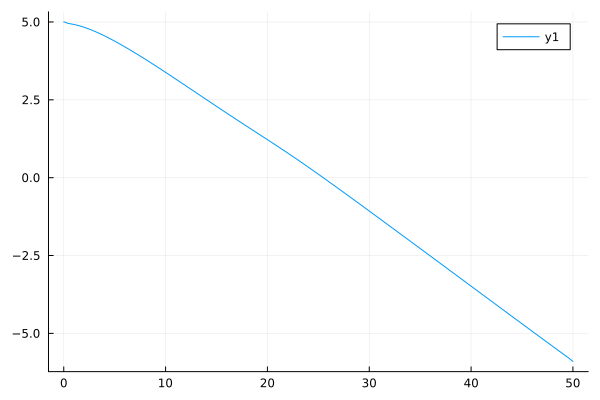

In [5]:
plot(tmpc1, Xmpc1[1,:])

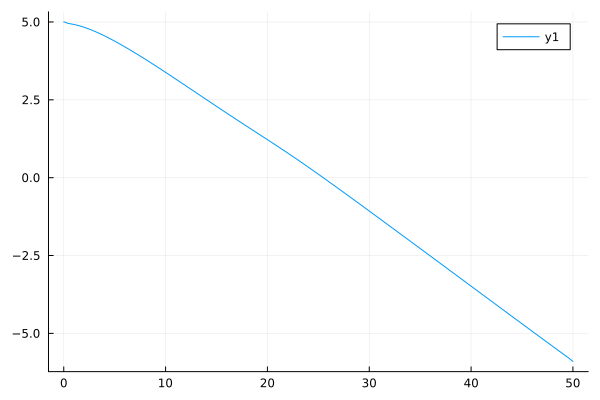

In [6]:
plot(tmpc1, Xmpc1[2,:])

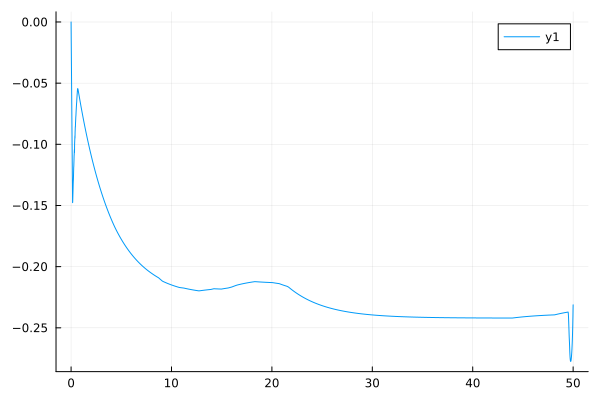

In [7]:
plot(tmpc1,Xmpc1[3,:])

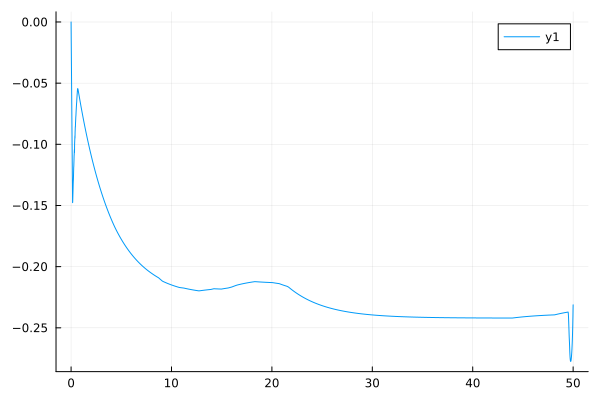

In [8]:
plot(tmpc1, Xmpc1[4,:])

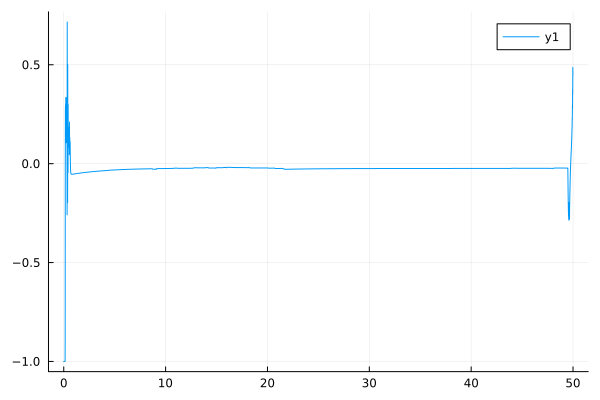

In [9]:
plot(tmpc1[1:length(tmpc1)-1],Umpc1[1,:])

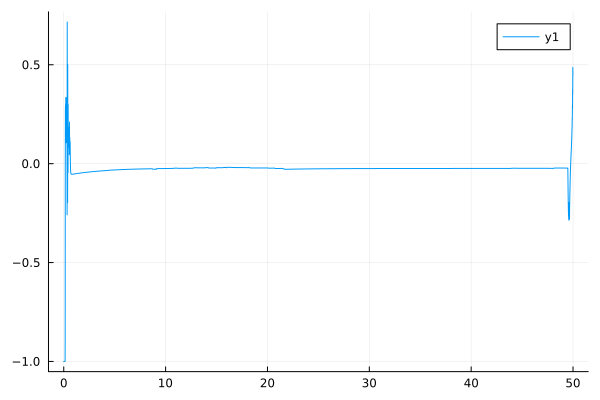

In [10]:
plot(tmpc1[1:length(tmpc1)-1], Umpc1[2,:])

┌ Info: Saved animation to 
│   fn = /home/ahmed/.julia/dev/ALMPC/examples/state_ref_MPC.gif
└ @ Plots /home/ahmed/.julia/packages/Plots/FCUr0/src/animation.jl:137


Plots.AnimatedGif("/home/ahmed/.julia/dev/ALMPC/examples/state_ref_MPC.gif")
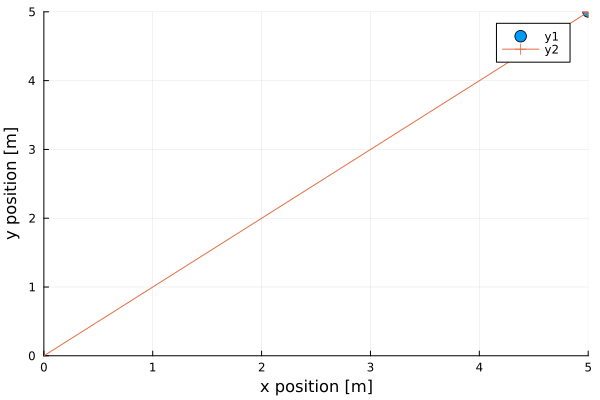

In [11]:
anim = @animate for i in 1:length(Xmpc1[1,:])
    scatter([Xmpc1[1,i]],
            [Xmpc1[2,i]], 
            m = (:circle, 6), 
            xlims = (0, 5),
            ylims = (0, 5),
            xlabel = "x position [m]",
            ylabel = "y position [m]")

    plot!([Xref[1]], [Xref[2]], m = (:cross, 6))
end every 10;
gif(anim, "state_ref_MPC.gif")